# Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets,models, transforms
import time
import sys
# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import random
import scipy.misc as m


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
# # # Dataset 1: Final abdomen images
# TRAIN_PATH1 = ['../allabdomen/train/skin_train2019/']
# MASK_PATH1 = ['../allabdomen/train/annotations/']
# train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# train_ids1.sort()
# mask_ids1.sort()
# TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# MASK_PATH1 = MASK_PATH1*len(train_ids1)

# # # Dataset 2: Augmented Abdomen Images
# TRAIN_PATH2 = ['../allabdomen/train/skin_augmented/']
# MASK_PATH2 = ['../allabdomen/train/annotations_augmented/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# # # Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2))
# MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2))
# train_ids = np.concatenate((train_ids1,train_ids2))
# mask_ids = np.concatenate((mask_ids1,mask_ids2))


# # Get and resize train images and masks DONT RUN IN THIS CODE
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH[n] + id_
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img

# for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#     path = MASK_PATH[n] + id_
#     img = imread(path)
#     #if n in range(899,977):
#         #img = img[:,:,1]
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     Y_train[n] = img

In [5]:
# # Check if training data looks all right
# ix = random.randint(0, len(train_ids))
# imshow(X_train[ix])
# plt.show()
# # imshow(np.squeeze(Y_train[436]))
# imshow(Y_train[ix][:,:,0])
# plt.show()

### For Loading testing Data

In [6]:
# # Dataset 1: Final abdomen images
# TRAIN_PATH_test = ['../../../../allabdomen/test/skin_test2019/']
# MASK_PATH_test = ['../../../../allabdomen/test/annotations/']
# train_ids_test = next(os.walk(TRAIN_PATH_test[0]))[2]
# mask_ids_test = next(os.walk(MASK_PATH_test[0]))[2]
# train_ids_test.sort()
# mask_ids_test.sort()
# TRAIN_PATH_test = TRAIN_PATH_test*len(train_ids_test)
# MASK_PATH_test = MASK_PATH_test*len(train_ids_test)

# X_test = np.zeros((len(train_ids_test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((len(train_ids_test), IMG_HEIGHT, IMG_WIDTH, 1),dtype=np.bool)
# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids_test), total=len(train_ids_test)):
#     path = TRAIN_PATH_test[n] + id_
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# for n, id_ in tqdm(enumerate(mask_ids_test), total=len(mask_ids_test)):
#     path = MASK_PATH_test[n] + id_
#     img = imread(path)
#     #if n in range(899,977):
#         #img = img[:,:,1]
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     Y_test[n] = img

In [7]:
# # Check if training data looks all right
# ix = random.randint(0, len(train_ids_test))
# imshow(X_test[ix])
# plt.show()
# # imshow(np.squeeze(Y_train[436]))
# imshow(Y_test[ix][:,:,0])
# plt.show()

In [8]:
# # Saving the Loaded train np arrays
# np.save('X_train.npy',X_train)
# np.save('Y_train.npy',Y_train)

# # Saving the Loaded test np arrays
# np.save('X_test.npy',X_test)
# np.save('Y_test.npy',Y_test)


In [9]:
# Loading the Training and Testing Data
trainImages = np.load('X_train.npy')
trainLabels = (np.load('Y_train.npy')*255).astype(np.uint8)

X_test = np.load('X_test.npy')
Y_test = (np.load('Y_test.npy')*255).astype(np.uint8)

# Splitting the Data into Training and Test Data
X_train, X_val,Y_train,Y_val = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.53766632 0.55240142 0.52007403], std: [0.27631814 0.25418144 0.28067154]


In [10]:
class SkinLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None, transform_label=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        
        if self.transform is not None:
            img = self.transform(img)
        if self.transform_label is not None:
            label = self.transform_label(label)
        return img, label
    

In [11]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =64
train_loader = torch.utils.data.DataLoader(
    SkinLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ]),transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
val_loader = torch.utils.data.DataLoader(
    SkinLoader(X_val, Y_val, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ]),transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])),shuffle=False)

test_loader = torch.utils.data.DataLoader(
    SkinLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ]),transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])),shuffle=False)

# The Images below are not unormalized yet and therefore the variation in rgb colors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


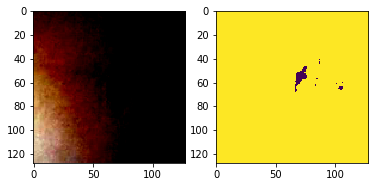

In [12]:
for img,lbl in train_loader:
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(img[0], (1,2,0)).numpy())
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(lbl[0],(1,2,0))[:,:,0].numpy())
    break
# plt.show()
# lbl.shape

## Tying Segnet


In [13]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


In [14]:
class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

In [15]:
class segnet(nn.Module):
    def __init__(self, n_classes=1, in_channels=3, is_unpooling=True):
        super(segnet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
net = segnet()
vgg16 = models.vgg16(pretrained=True)
net.init_vgg16_params(vgg16)
net.to(device)
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
net

DataParallel(
  (module): segnet(
    (down1): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (conv2): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (maxpool_with_argmax): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (down2): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tra

## Trying PSPNet

In [16]:
# class _PyramidPoolingModule(nn.Module):
#     def __init__(self, in_dim, reduction_dim, setting):
#         super(_PyramidPoolingModule, self).__init__()
#         self.features = []
#         for s in setting:
#             self.features.append(nn.Sequential(
#                 nn.AdaptiveAvgPool2d(s),
#                 nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
#                 nn.BatchNorm2d(reduction_dim, momentum=.95),
#                 nn.ReLU(inplace=True)
#             ))
#         self.features = nn.ModuleList(self.features)

#     def forward(self, x):
#         x_size = x.size()
#         out = [x]
#         for f in self.features:
#             out.append(F.upsample(f(x), x_size[2:], mode='bilinear'))
#         out = torch.cat(out, 1)
#         return out

# class PSPNet(nn.Module):
#     def __init__(self, num_classes, pretrained=True, use_aux=True):
#         super(PSPNet, self).__init__()
#         self.use_aux = use_aux
#         resnet = models.resnet101()
#         if pretrained:
#             resnet.load_state_dict(torch.load('../../resnet101-5d3b4d8f.pth'))
#         self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
#         self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

#         for n, m in self.layer3.named_modules():
#             if 'conv2' in n:
#                 m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
#             elif 'downsample.0' in n:
#                 m.stride = (1, 1)
#         for n, m in self.layer4.named_modules():
#             if 'conv2' in n:
#                 m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
#             elif 'downsample.0' in n:
#                 m.stride = (1, 1)

#         self.ppm = _PyramidPoolingModule(2048, 512, (1, 2, 3, 6))
#         self.final = nn.Sequential(
#             nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(512, momentum=.95),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),
#             nn.Conv2d(512, num_classes, kernel_size=1)
#         )

#         if use_aux:
#             self.aux_logits = nn.Conv2d(1024, num_classes, kernel_size=1)
#             initialize_weights(self.aux_logits)

#         initialize_weights(self.ppm, self.final)

#     def forward(self, x):
#         x_size = x.size()
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         if self.training and self.use_aux:
#             aux = self.aux_logits(x)
#         x = self.layer4(x)
#         x = self.ppm(x)
#         x = self.final(x)
#         if self.training and self.use_aux:
#             return F.upsample(x, x_size[2:], mode='bilinear'), F.upsample(aux, x_size[2:], mode='bilinear')
#         return F.upsample(x, x_size[2:], mode='bilinear')
    
# def initialize_weights(*models):
#     for model in models:
#         for module in model.modules():
#             if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
#                 nn.init.kaiming_normal(module.weight)
#                 if module.bias is not None:
#                     module.bias.data.zero_()
#             elif isinstance(module, nn.BatchNorm2d):
#                 module.weight.data.fill_(1)    
#                 module.bias.data.zero_()
# net = PSPNet(num_classes=1)
# net.to(device)

In [17]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
# summary(net,(3,32,32),batch_size=batch_size)

In [18]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=255):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average, ignore_index)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)

In [19]:
import torch.optim as optim
# criterion = nn.CrossEntropyLoss() 
criterion =  nn.BCELoss()
# criterion = CrossEntropyLoss2d(size_average=True)# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)

In [20]:
# # # For Debugging
# for batch_idx, (data, target) in enumerate(test_loader):
# #     data, target = data.to(device), target.to(device)
#     optimizer.zero_grad()
#     output = net(data)
#     break
# data.shape
# target.shape

In [21]:
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()
# train_hist['train_loss'].append(loss.item())

In [22]:
train_hist = {}
train_hist['train_loss'] = []
train_hist['test_loss'] = []
train_hist['train_loss_epoch'] = []
train_hist['test_loss_epoch'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []
train_hist['train_accu'] = []
train_hist['test_accu'] = []
epochs = 500


## Training and Testing Functions

In [23]:
def train(model):
    print('training start!!')
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
#         training_loss = 0
        train_correct = 0
        lo = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            #==== Forward Pass=====
            output = model(data)
            output[output>1] =1
            output[output<1] =0
            loss = criterion(output, target)
            #=====Backward Pass=======
            loss.backward()
            optimizer.step()
            #=== Loss Append to get loss of entire Batch====
            train_hist['train_loss'].append(loss.item())
            #==== Calculating Training Accuracy========= 
            train_correct += output.eq(target).sum().item()
            #======= Logging results after every 20th batch============ 
            if batch_idx % 20 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
        train_hist['train_accu'].append(100 * (train_correct / (Y_train.shape[0]*128*128)))
        #======== Getting Training Loss of the epoch by averaging across each batch
        train_hist['train_loss_epoch'].append(np.mean(train_hist['train_loss']))
        test(model)

def test(model):
    test_loss = 0
    correct = 0
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            output[output>1] =1
            output[output<1] =0
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            train_hist['test_loss'].append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            correct += output.eq(target).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    train_hist['test_accu'].append(100. * correct / (Y_val.shape[0]*128*128))
    #====== Getting Testing Error of Epoch========
    train_hist['test_loss_epoch'].append(np.mean(train_hist['test_loss']))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(train_hist['test_loss']), correct, val_loader.dataset.y_arr.size,
        100 * correct / (Y_val.shape[0]*128*128)))
    

# Training the Model

In [24]:
train(net)

training start!!
Train Epoch: 0 [0/3276 (0%)]	Loss: 17.344385
Train Epoch: 0 [1280/3276 (38%)]	Loss: 19.759876
Train Epoch: 0 [2560/3276 (77%)]	Loss: 16.813889

Test set: Average loss: 17.8590, Accuracy: 3354950/9486336 (35%)

Train Epoch: 1 [0/3276 (0%)]	Loss: 18.003214
Train Epoch: 1 [1280/3276 (38%)]	Loss: 18.476240
Train Epoch: 1 [2560/3276 (77%)]	Loss: 17.897308

Test set: Average loss: 17.7884, Accuracy: 3403442/9486336 (36%)

Train Epoch: 2 [0/3276 (0%)]	Loss: 18.582699
Train Epoch: 2 [1280/3276 (38%)]	Loss: 17.777491
Train Epoch: 2 [2560/3276 (77%)]	Loss: 19.860830

Test set: Average loss: 17.7649, Accuracy: 3403359/9486336 (36%)

Train Epoch: 3 [0/3276 (0%)]	Loss: 19.437975
Train Epoch: 3 [1280/3276 (38%)]	Loss: 18.141926
Train Epoch: 3 [2560/3276 (77%)]	Loss: 18.203165

Test set: Average loss: 17.7532, Accuracy: 3403358/9486336 (36%)

Train Epoch: 4 [0/3276 (0%)]	Loss: 18.646704
Train Epoch: 4 [1280/3276 (38%)]	Loss: 18.114336
Train Epoch: 4 [2560/3276 (77%)]	Loss: 18.095707



Test set: Average loss: 17.7216, Accuracy: 3403360/9486336 (36%)

Train Epoch: 39 [0/3276 (0%)]	Loss: 18.828503
Train Epoch: 39 [1280/3276 (38%)]	Loss: 18.110041
Train Epoch: 39 [2560/3276 (77%)]	Loss: 18.242428

Test set: Average loss: 17.7215, Accuracy: 3403369/9486336 (36%)

Train Epoch: 40 [0/3276 (0%)]	Loss: 18.372892
Train Epoch: 40 [1280/3276 (38%)]	Loss: 17.989168
Train Epoch: 40 [2560/3276 (77%)]	Loss: 18.734718

Test set: Average loss: 17.7214, Accuracy: 3403373/9486336 (36%)

Train Epoch: 41 [0/3276 (0%)]	Loss: 17.868956
Train Epoch: 41 [1280/3276 (38%)]	Loss: 18.170410
Train Epoch: 41 [2560/3276 (77%)]	Loss: 17.719439

Test set: Average loss: 17.7214, Accuracy: 3403373/9486336 (36%)

Train Epoch: 42 [0/3276 (0%)]	Loss: 17.905266
Train Epoch: 42 [1280/3276 (38%)]	Loss: 18.695850
Train Epoch: 42 [2560/3276 (77%)]	Loss: 17.812984

Test set: Average loss: 17.7213, Accuracy: 3403378/9486336 (36%)

Train Epoch: 43 [0/3276 (0%)]	Loss: 18.441404
Train Epoch: 43 [1280/3276 (38%)]	L

Train Epoch: 77 [1280/3276 (38%)]	Loss: 17.949009
Train Epoch: 77 [2560/3276 (77%)]	Loss: 19.561823

Test set: Average loss: 17.8197, Accuracy: 3276245/9486336 (35%)

Train Epoch: 78 [0/3276 (0%)]	Loss: 18.293497
Train Epoch: 78 [1280/3276 (38%)]	Loss: 18.746655
Train Epoch: 78 [2560/3276 (77%)]	Loss: 19.239763

Test set: Average loss: 17.8231, Accuracy: 3276245/9486336 (35%)

Train Epoch: 79 [0/3276 (0%)]	Loss: 17.805872
Train Epoch: 79 [1280/3276 (38%)]	Loss: 17.577225
Train Epoch: 79 [2560/3276 (77%)]	Loss: 18.885708

Test set: Average loss: 17.8265, Accuracy: 3276245/9486336 (35%)

Train Epoch: 80 [0/3276 (0%)]	Loss: 19.089508
Train Epoch: 80 [1280/3276 (38%)]	Loss: 18.602463
Train Epoch: 80 [2560/3276 (77%)]	Loss: 17.294268

Test set: Average loss: 17.8297, Accuracy: 3276245/9486336 (35%)

Train Epoch: 81 [0/3276 (0%)]	Loss: 18.250912
Train Epoch: 81 [1280/3276 (38%)]	Loss: 18.195312
Train Epoch: 81 [2560/3276 (77%)]	Loss: 18.040922

Test set: Average loss: 17.8328, Accuracy: 3276


Test set: Average loss: 17.9077, Accuracy: 3276245/9486336 (35%)

Train Epoch: 116 [0/3276 (0%)]	Loss: 17.506893
Train Epoch: 116 [1280/3276 (38%)]	Loss: 19.150879
Train Epoch: 116 [2560/3276 (77%)]	Loss: 18.207672

Test set: Average loss: 17.9092, Accuracy: 3276245/9486336 (35%)

Train Epoch: 117 [0/3276 (0%)]	Loss: 18.505621
Train Epoch: 117 [1280/3276 (38%)]	Loss: 18.221981
Train Epoch: 117 [2560/3276 (77%)]	Loss: 17.683235

Test set: Average loss: 17.9108, Accuracy: 3276245/9486336 (35%)

Train Epoch: 118 [0/3276 (0%)]	Loss: 17.495537
Train Epoch: 118 [1280/3276 (38%)]	Loss: 17.624050
Train Epoch: 118 [2560/3276 (77%)]	Loss: 17.993254

Test set: Average loss: 17.9122, Accuracy: 3276245/9486336 (35%)

Train Epoch: 119 [0/3276 (0%)]	Loss: 18.790424
Train Epoch: 119 [1280/3276 (38%)]	Loss: 17.365547
Train Epoch: 119 [2560/3276 (77%)]	Loss: 16.574093

Test set: Average loss: 17.9137, Accuracy: 3276245/9486336 (35%)

Train Epoch: 120 [0/3276 (0%)]	Loss: 18.231491
Train Epoch: 120 [1280


Test set: Average loss: 17.9522, Accuracy: 3276245/9486336 (35%)

Train Epoch: 154 [0/3276 (0%)]	Loss: 17.872065
Train Epoch: 154 [1280/3276 (38%)]	Loss: 18.740252
Train Epoch: 154 [2560/3276 (77%)]	Loss: 17.552113

Test set: Average loss: 17.9531, Accuracy: 3276245/9486336 (35%)

Train Epoch: 155 [0/3276 (0%)]	Loss: 18.715851
Train Epoch: 155 [1280/3276 (38%)]	Loss: 18.217842
Train Epoch: 155 [2560/3276 (77%)]	Loss: 17.385653

Test set: Average loss: 17.9540, Accuracy: 3276245/9486336 (35%)

Train Epoch: 156 [0/3276 (0%)]	Loss: 18.275843
Train Epoch: 156 [1280/3276 (38%)]	Loss: 18.940414
Train Epoch: 156 [2560/3276 (77%)]	Loss: 18.485411

Test set: Average loss: 17.9548, Accuracy: 3276245/9486336 (35%)

Train Epoch: 157 [0/3276 (0%)]	Loss: 19.122526
Train Epoch: 157 [1280/3276 (38%)]	Loss: 20.054796
Train Epoch: 157 [2560/3276 (77%)]	Loss: 19.524139

Test set: Average loss: 17.9557, Accuracy: 3276245/9486336 (35%)

Train Epoch: 158 [0/3276 (0%)]	Loss: 18.926607
Train Epoch: 158 [1280


Test set: Average loss: 17.9792, Accuracy: 3276245/9486336 (35%)

Train Epoch: 192 [0/3276 (0%)]	Loss: 18.122110
Train Epoch: 192 [1280/3276 (38%)]	Loss: 18.458269
Train Epoch: 192 [2560/3276 (77%)]	Loss: 19.608412

Test set: Average loss: 17.9797, Accuracy: 3276245/9486336 (35%)

Train Epoch: 193 [0/3276 (0%)]	Loss: 18.932299
Train Epoch: 193 [1280/3276 (38%)]	Loss: 18.125851
Train Epoch: 193 [2560/3276 (77%)]	Loss: 18.210859

Test set: Average loss: 17.9803, Accuracy: 3276245/9486336 (35%)

Train Epoch: 194 [0/3276 (0%)]	Loss: 16.985853
Train Epoch: 194 [1280/3276 (38%)]	Loss: 19.113119
Train Epoch: 194 [2560/3276 (77%)]	Loss: 18.050566

Test set: Average loss: 17.9808, Accuracy: 3276245/9486336 (35%)

Train Epoch: 195 [0/3276 (0%)]	Loss: 18.274101
Train Epoch: 195 [1280/3276 (38%)]	Loss: 17.696226
Train Epoch: 195 [2560/3276 (77%)]	Loss: 18.186300

Test set: Average loss: 17.9814, Accuracy: 3276245/9486336 (35%)

Train Epoch: 196 [0/3276 (0%)]	Loss: 18.008274
Train Epoch: 196 [1280


Test set: Average loss: 17.9972, Accuracy: 3276245/9486336 (35%)

Train Epoch: 230 [0/3276 (0%)]	Loss: 16.378252
Train Epoch: 230 [1280/3276 (38%)]	Loss: 18.388939
Train Epoch: 230 [2560/3276 (77%)]	Loss: 19.419371

Test set: Average loss: 17.9976, Accuracy: 3276245/9486336 (35%)

Train Epoch: 231 [0/3276 (0%)]	Loss: 17.672905
Train Epoch: 231 [1280/3276 (38%)]	Loss: 18.904945
Train Epoch: 231 [2560/3276 (77%)]	Loss: 17.352659

Test set: Average loss: 17.9980, Accuracy: 3276245/9486336 (35%)

Train Epoch: 232 [0/3276 (0%)]	Loss: 18.395975
Train Epoch: 232 [1280/3276 (38%)]	Loss: 18.915144
Train Epoch: 232 [2560/3276 (77%)]	Loss: 17.901657

Test set: Average loss: 17.9984, Accuracy: 3276245/9486336 (35%)

Train Epoch: 233 [0/3276 (0%)]	Loss: 18.194918
Train Epoch: 233 [1280/3276 (38%)]	Loss: 17.930696
Train Epoch: 233 [2560/3276 (77%)]	Loss: 17.559883

Test set: Average loss: 17.9987, Accuracy: 3276245/9486336 (35%)

Train Epoch: 234 [0/3276 (0%)]	Loss: 19.233490
Train Epoch: 234 [1280


Test set: Average loss: 18.0101, Accuracy: 3276245/9486336 (35%)

Train Epoch: 268 [0/3276 (0%)]	Loss: 17.741417
Train Epoch: 268 [1280/3276 (38%)]	Loss: 18.877222
Train Epoch: 268 [2560/3276 (77%)]	Loss: 17.758440

Test set: Average loss: 18.0104, Accuracy: 3276245/9486336 (35%)

Train Epoch: 269 [0/3276 (0%)]	Loss: 19.556131
Train Epoch: 269 [1280/3276 (38%)]	Loss: 18.843996
Train Epoch: 269 [2560/3276 (77%)]	Loss: 18.055494

Test set: Average loss: 18.0107, Accuracy: 3276245/9486336 (35%)

Train Epoch: 270 [0/3276 (0%)]	Loss: 18.723703
Train Epoch: 270 [1280/3276 (38%)]	Loss: 18.987240
Train Epoch: 270 [2560/3276 (77%)]	Loss: 18.609287

Test set: Average loss: 18.0110, Accuracy: 3276245/9486336 (35%)

Train Epoch: 271 [0/3276 (0%)]	Loss: 18.122980
Train Epoch: 271 [1280/3276 (38%)]	Loss: 18.888739
Train Epoch: 271 [2560/3276 (77%)]	Loss: 17.063932

Test set: Average loss: 18.0112, Accuracy: 3276245/9486336 (35%)

Train Epoch: 272 [0/3276 (0%)]	Loss: 19.330540
Train Epoch: 272 [1280


Test set: Average loss: 18.0198, Accuracy: 3276245/9486336 (35%)

Train Epoch: 306 [0/3276 (0%)]	Loss: 18.717300
Train Epoch: 306 [1280/3276 (38%)]	Loss: 18.027166
Train Epoch: 306 [2560/3276 (77%)]	Loss: 18.676062

Test set: Average loss: 18.0200, Accuracy: 3276245/9486336 (35%)

Train Epoch: 307 [0/3276 (0%)]	Loss: 17.579807
Train Epoch: 307 [1280/3276 (38%)]	Loss: 16.868277
Train Epoch: 307 [2560/3276 (77%)]	Loss: 17.573824

Test set: Average loss: 18.0202, Accuracy: 3276245/9486336 (35%)

Train Epoch: 308 [0/3276 (0%)]	Loss: 17.695354
Train Epoch: 308 [1280/3276 (38%)]	Loss: 18.407410
Train Epoch: 308 [2560/3276 (77%)]	Loss: 18.738485

Test set: Average loss: 18.0205, Accuracy: 3276245/9486336 (35%)

Train Epoch: 309 [0/3276 (0%)]	Loss: 18.191149
Train Epoch: 309 [1280/3276 (38%)]	Loss: 17.662733
Train Epoch: 309 [2560/3276 (77%)]	Loss: 18.511051

Test set: Average loss: 18.0207, Accuracy: 3276245/9486336 (35%)

Train Epoch: 310 [0/3276 (0%)]	Loss: 18.534845
Train Epoch: 310 [1280


Test set: Average loss: 18.0274, Accuracy: 3276245/9486336 (35%)

Train Epoch: 344 [0/3276 (0%)]	Loss: 18.406332
Train Epoch: 344 [1280/3276 (38%)]	Loss: 18.974751
Train Epoch: 344 [2560/3276 (77%)]	Loss: 17.285940

Test set: Average loss: 18.0275, Accuracy: 3276245/9486336 (35%)

Train Epoch: 345 [0/3276 (0%)]	Loss: 17.355268
Train Epoch: 345 [1280/3276 (38%)]	Loss: 18.021713
Train Epoch: 345 [2560/3276 (77%)]	Loss: 17.454691

Test set: Average loss: 18.0277, Accuracy: 3276245/9486336 (35%)

Train Epoch: 346 [0/3276 (0%)]	Loss: 16.433407
Train Epoch: 346 [1280/3276 (38%)]	Loss: 18.781624
Train Epoch: 346 [2560/3276 (77%)]	Loss: 17.041639

Test set: Average loss: 18.0279, Accuracy: 3276245/9486336 (35%)

Train Epoch: 347 [0/3276 (0%)]	Loss: 20.963882
Train Epoch: 347 [1280/3276 (38%)]	Loss: 18.414818
Train Epoch: 347 [2560/3276 (77%)]	Loss: 16.966145

Test set: Average loss: 18.0281, Accuracy: 3276245/9486336 (35%)

Train Epoch: 348 [0/3276 (0%)]	Loss: 18.040133
Train Epoch: 348 [1280


Test set: Average loss: 18.0334, Accuracy: 3276245/9486336 (35%)

Train Epoch: 382 [0/3276 (0%)]	Loss: 17.462175
Train Epoch: 382 [1280/3276 (38%)]	Loss: 18.316818
Train Epoch: 382 [2560/3276 (77%)]	Loss: 17.375561

Test set: Average loss: 18.0336, Accuracy: 3276245/9486336 (35%)

Train Epoch: 383 [0/3276 (0%)]	Loss: 19.277599
Train Epoch: 383 [1280/3276 (38%)]	Loss: 18.810793
Train Epoch: 383 [2560/3276 (77%)]	Loss: 17.429920

Test set: Average loss: 18.0337, Accuracy: 3276245/9486336 (35%)

Train Epoch: 384 [0/3276 (0%)]	Loss: 18.264299
Train Epoch: 384 [1280/3276 (38%)]	Loss: 17.973122
Train Epoch: 384 [2560/3276 (77%)]	Loss: 18.018417

Test set: Average loss: 18.0338, Accuracy: 3276245/9486336 (35%)

Train Epoch: 385 [0/3276 (0%)]	Loss: 19.689098
Train Epoch: 385 [1280/3276 (38%)]	Loss: 19.236044
Train Epoch: 385 [2560/3276 (77%)]	Loss: 18.643095

Test set: Average loss: 18.0340, Accuracy: 3276245/9486336 (35%)

Train Epoch: 386 [0/3276 (0%)]	Loss: 18.882257
Train Epoch: 386 [1280


Test set: Average loss: 18.0384, Accuracy: 3276245/9486336 (35%)

Train Epoch: 420 [0/3276 (0%)]	Loss: 17.720942
Train Epoch: 420 [1280/3276 (38%)]	Loss: 18.293127
Train Epoch: 420 [2560/3276 (77%)]	Loss: 18.267803

Test set: Average loss: 18.0385, Accuracy: 3276245/9486336 (35%)

Train Epoch: 421 [0/3276 (0%)]	Loss: 19.034039
Train Epoch: 421 [1280/3276 (38%)]	Loss: 17.823843
Train Epoch: 421 [2560/3276 (77%)]	Loss: 17.404940

Test set: Average loss: 18.0386, Accuracy: 3276245/9486336 (35%)

Train Epoch: 422 [0/3276 (0%)]	Loss: 19.620060
Train Epoch: 422 [1280/3276 (38%)]	Loss: 17.628212
Train Epoch: 422 [2560/3276 (77%)]	Loss: 17.618015

Test set: Average loss: 18.0387, Accuracy: 3276245/9486336 (35%)

Train Epoch: 423 [0/3276 (0%)]	Loss: 18.568916
Train Epoch: 423 [1280/3276 (38%)]	Loss: 18.554478
Train Epoch: 423 [2560/3276 (77%)]	Loss: 18.446781

Test set: Average loss: 18.0388, Accuracy: 3276245/9486336 (35%)

Train Epoch: 424 [0/3276 (0%)]	Loss: 17.898441
Train Epoch: 424 [1280


Test set: Average loss: 18.0425, Accuracy: 3276245/9486336 (35%)

Train Epoch: 458 [0/3276 (0%)]	Loss: 18.791582
Train Epoch: 458 [1280/3276 (38%)]	Loss: 17.479225
Train Epoch: 458 [2560/3276 (77%)]	Loss: 18.832375

Test set: Average loss: 18.0426, Accuracy: 3276245/9486336 (35%)

Train Epoch: 459 [0/3276 (0%)]	Loss: 18.574505
Train Epoch: 459 [1280/3276 (38%)]	Loss: 17.775356
Train Epoch: 459 [2560/3276 (77%)]	Loss: 17.868666

Test set: Average loss: 18.0427, Accuracy: 3276245/9486336 (35%)

Train Epoch: 460 [0/3276 (0%)]	Loss: 18.103664
Train Epoch: 460 [1280/3276 (38%)]	Loss: 18.563673
Train Epoch: 460 [2560/3276 (77%)]	Loss: 18.962681

Test set: Average loss: 18.0428, Accuracy: 3276245/9486336 (35%)

Train Epoch: 461 [0/3276 (0%)]	Loss: 17.350130
Train Epoch: 461 [1280/3276 (38%)]	Loss: 17.967876
Train Epoch: 461 [2560/3276 (77%)]	Loss: 18.660276

Test set: Average loss: 18.0429, Accuracy: 3276245/9486336 (35%)

Train Epoch: 462 [0/3276 (0%)]	Loss: 16.983482
Train Epoch: 462 [1280


Test set: Average loss: 18.0460, Accuracy: 3276245/9486336 (35%)

Train Epoch: 496 [0/3276 (0%)]	Loss: 17.557775
Train Epoch: 496 [1280/3276 (38%)]	Loss: 17.414454
Train Epoch: 496 [2560/3276 (77%)]	Loss: 19.401424

Test set: Average loss: 18.0461, Accuracy: 3276245/9486336 (35%)

Train Epoch: 497 [0/3276 (0%)]	Loss: 19.688623
Train Epoch: 497 [1280/3276 (38%)]	Loss: 18.162401
Train Epoch: 497 [2560/3276 (77%)]	Loss: 16.591221

Test set: Average loss: 18.0462, Accuracy: 3276245/9486336 (35%)

Train Epoch: 498 [0/3276 (0%)]	Loss: 18.301218
Train Epoch: 498 [1280/3276 (38%)]	Loss: 17.904922
Train Epoch: 498 [2560/3276 (77%)]	Loss: 17.367075

Test set: Average loss: 18.0463, Accuracy: 3276245/9486336 (35%)

Train Epoch: 499 [0/3276 (0%)]	Loss: 18.708023
Train Epoch: 499 [1280/3276 (38%)]	Loss: 18.242165
Train Epoch: 499 [2560/3276 (77%)]	Loss: 18.277739

Test set: Average loss: 18.0464, Accuracy: 3276245/9486336 (35%)



Training Loss: 18.16876692680212
Training Accuracy: 34.256763947315704

Test Loss: 17.957023267353808
Testing Accuracy: 18.04635659245794



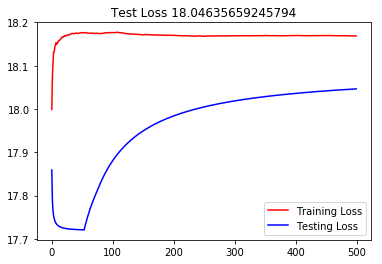

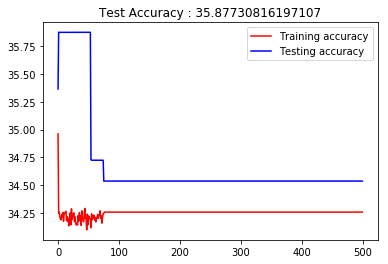

In [28]:
# Evaluate Accuracy
print('Training Loss:', train_hist['train_loss_epoch'][-1])
print('Training Accuracy:', train_hist['train_accu'][-1])
print()
print('Test Loss:', np.mean(train_hist['test_loss_epoch']))
print('Testing Accuracy:', np.max(train_hist['test_loss_epoch']))
print()

plt.plot(train_hist['train_loss_epoch'],'r', label='Training Loss')
plt.plot(train_hist['test_loss_epoch'],'b', label='Testing Loss')
plt.title('Test Loss ' + str(train_hist['test_loss_epoch'][-1]))
plt.legend()
plt.show()
plt.plot(train_hist['train_accu'],'r', label='Training accuracy')
plt.plot(train_hist['test_accu'],'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(train_hist['test_accu'])))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

## Correct Predictions

In [63]:
img = []
mask = []
pred= []
with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        #==== Getting the Prediction====
        output = net(data)
#         output[output>1] =1
#         output[output<1] =0
        img.append(np.transpose(data[0], (1,2,0)).numpy())
        mask.append(np.transpose(target[0], (1,2,0))[:,:,0].numpy())
        pred.append(np.transpose(output[0], (1,2,0))[:,:,0].numpy())
#         break
# # output[0].shape
# plt.subplot(1,2,1)
# plt.imshow(np.transpose(data[0], (1,2,0))[:,:,0].numpy())
# plt.subplot(1,2,2)
# plt.imshow(np.transpose(output[0],(1,2,0))[:,:,0].numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


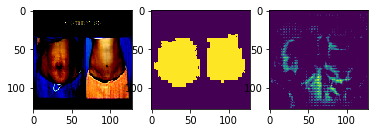

In [64]:
import random
num = random.randint(1,100)
plt.subplot(1,3,1)
plt.imshow(img[num])
plt.subplot(1,3,2)
plt.imshow(mask[num])
plt.subplot(1,3,3)
plt.imshow(pred[num])
plt.show()


In [51]:
torch.min(output)

tensor(0., device='cuda:0')